In [844]:
import os
from typing import Tuple, List, Iterable, Callable

import math
import numpy as np
from scipy.stats import halfcauchy, invgamma
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy import stats

from itertools import chain, combinations

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'cvxpy'

## Sources

#### BOCS

Baptista, Poloczek (2018) - Bayesian Optimization of Combinatorial Structures

##### Sparse Bayesian Regression
Makalic, Schmidt (2015) - A simple sampler for the horseshoe estimator [Link](https://arxiv.org/pdf/1508.03884.pdf)

## 1. Define Trivial binary function 

$$ g: \mathcal{D} \longrightarrow \mathbb{R} $$
    
where $\mathcal{D}$ is a combinatorial domain (e.g. a set of graphs or molecule structrues). Let $\mathcal{D} = \{1,2,...,d \}$. 

For some $\delta \in \mathcal{D}$, $g(\delta)$ describes the scalar-valued property of graph (e.g. overall utility of a network of bike stations or the solubility of a drug-like molecule).

We model $f$ as affine-linear in presence of each of the $2^{|\mathcal{D}|}$ possible components in $\mathcal{D}$. In particular, let the dummy variable $x_{i}$ describe if a component is present in the combinatorial structure (e.g. a node in a graph or an element in a molecule). In particular, $x_{i} = \mathbb{1}\{ \delta_{i} \in \delta \}$. Restrict to interactions up to order $2$.

$$ f_{\boldsymbol{\alpha}} = \alpha_{0} + \sum_{j=1}^{d} \alpha_{j} x_{j} + \sum_{i<j}^{d} \alpha_{ij}x_{i}x_{j} $$

with $\boldsymbol{\alpha} = (\alpha_{i}, \alpha_{ij}) \in \mathbb{R}^{p}$, $\alpha_{i} \in \mathbb{R}$ and $p=1+d+\binom{d}{k}$.

Let a sample function $f_{1} = \sum \limits_{k \in 2^{|\mathcal{D}|}} \prod \limits_{i=1}^{d} \alpha_{k_{i}} x_{i}$ to be continued.

In [611]:
def powerset(x:Iterable):
    '''
    Powerset (set of subsets) for a given iterable x incl. ∅
    '''
    s = list(x)
    powerSet = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
    return list(powerSet)

def gDict(d:int, k:int, seed:int=3256, eTol:float=10E-2) -> dict:
    '''
    Black-box function for combinatorial optimization (example model problem)
    x    : input tuple   
    d    : dimension |D|
    k    : order of polynomials w/ significant (from 0) coefficients
    seed : seed for generation of random coefficients
    '''
    
    # a : compute groundtruth coefficients
    k_sig = sum([math.comb(d,i) for i in range(k+1)])
    np.random.seed(seed)
    a = np.random.normal(size=2**d, loc=0, scale=7)
    #a[k_sig:] = np.random.normal(size=len(a[k_sig:]), loc=0, scale=eTol) # reduce order of magnitude by factor of 10 for non-sifnificant orders
    a = a.round(4)
    
    a[k_sig:] = 0
    
    # dict
    g_of_x_dict = {k:v for k,v in zip(powerset(range(d)), a)}
    
    # g(x)
    return g_of_x_dict, a

def g(x:Iterable, g_dict:dict) -> float:
    '''
    Compute g(x) given x and d dictionary
    '''
    # binary to index
    x = [i for i,x_i in enumerate(x) if x_i==1]
    powSet = powerset(x)
    
    #print(f'x: {x},\npowSet: {powSet}\nmatch-len:', len(([g_dict[x_i] for x_i in powSet if x_i in g_dict])), '\n g(x):', sum([g_dict[x_i] for x_i in powSet if x_i in g_dict]))
    #print()
    
    return sum([g_dict[x_i] for x_i in powSet if x_i in g_dict])

def getX(n:int, d:int, k:int, prob:float=0.4, seed:int=3256) -> np.array:
    '''
    X ∈ R^{n x p}
    p: column order (derived from 1 (intercept.) + d (dim. of input) + (d over 2) + ... (d over k))
    '''
    # 
    if(k==0):
        return np.ones((n,1))
    
    # generate column-values {1,...d}
    X = np.random.binomial(n=1, p=prob, size=n*d).reshape((n,d))
    
    #print("X.shape: ", X.shape)
    
    # extend to canonical form (intercept, 1,...,d, 2nd order terms, 3rd order terms etc.)
    p = sum([math.comb(d,i) for i in range(k+1)])
    X_can = np.zeros((n,p))
    #print("X_can.shape: ", X_can.shape)
    pSet = powerset(range(d))
    for i,Xrow in enumerate(X):
        x_repr = [i for i,x_i in enumerate(Xrow) if x_i==1]
        X_can[i,:] = np.array([1 if (x in powerset(x_repr)) else 0 for x in pSet[:p]])
    # rename
    X = X_can
    
    # intercept column
    X[:,0] = 1 
    
    return X

def getY(X:np.array, d:int, g_dict:dict, errorFlag:bool=False, sigma:float=0.1) -> np.array:
    '''
    Compute function value y given black-box function g and binary input matrix of dimemension 
    '''
    y = np.zeros(len(X))
    
    # populate
    for i,xRow_i in enumerate(X):
        y[i] = g(xRow_i[1:1+d], g_dict=g_dict)
        
    # additive Gaussian error
    if(errorFlag):
        print('Flag, min()=', min(y))
        y += np.random.normal(size=len(y), loc=0, scale=sigma)
    
    return y

In [640]:
# parameters
n, d, k = 50, 12, 2

# generate dataset
gD, a_GT = gDict(d=d, k=k)

X = getX(n=n, d=d, k=k)
y = getY(X, d=d, g_dict=gD, errorFlag=False, sigma=0.2)

#X_tr
min(y)

-65.9476

## 1 Sampling Basics: Parametrize the Inverse Gamme Distributions properly
Inverse Gamma distribution simulatin
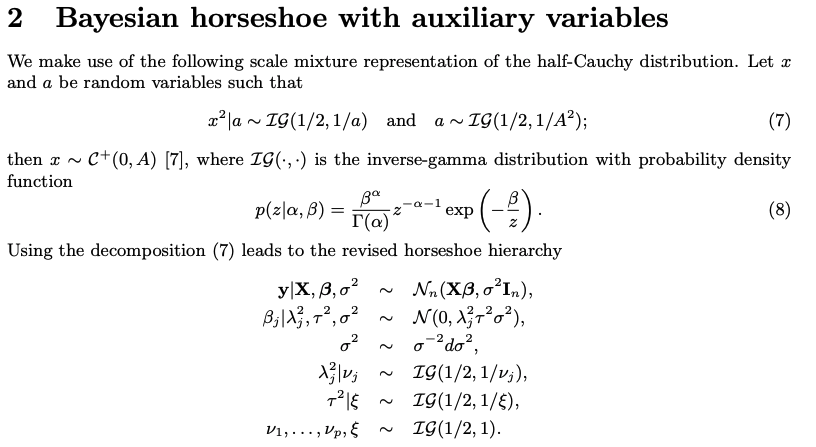

In [641]:
%%time 

N = 10000

# para
A = 3
a = invgamma.rvs(0.5, scale=1./(A**2), size=N)

# dataset 1
dset1 = invgamma.rvs(0.5 * np.ones(len(a)), scale=1./a, size=N)
dset1 = np.sqrt(dset1)

# dset 2
dset2 = halfcauchy.rvs(loc=0, scale=A, size=N)


# Compare
print(round(np.quantile(dset1, 0.25), 3), '\t', round(np.quantile(dset1, 0.5), 3), '\t', round(np.quantile(dset1, 0.75), 3))
print(round(np.quantile(dset2, 0.25), 3), '\t', round(np.quantile(dset2, 0.5), 3), '\t', round(np.quantile(dset2, 0.75), 3))


1.228 	 2.929 	 7.073
1.202 	 2.983 	 7.112
CPU times: user 96.5 ms, sys: 2.4 ms, total: 98.9 ms
Wall time: 135 ms


## 2. Sparse Bayesian Regression 

#### Re-factor code from `bhs.py`

## P1 : Statistical Model
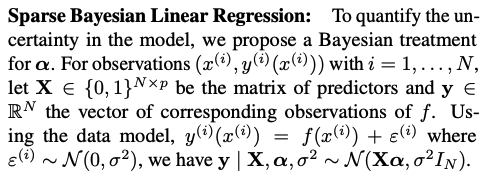

## P2 : Prior Distribution
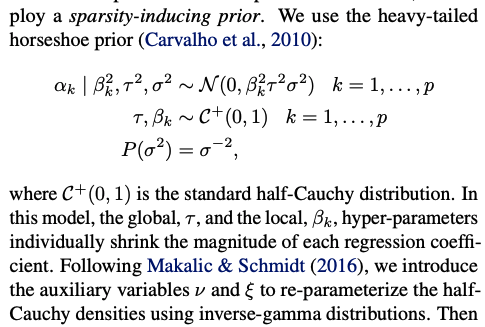

## P3 : Posterior Distribution
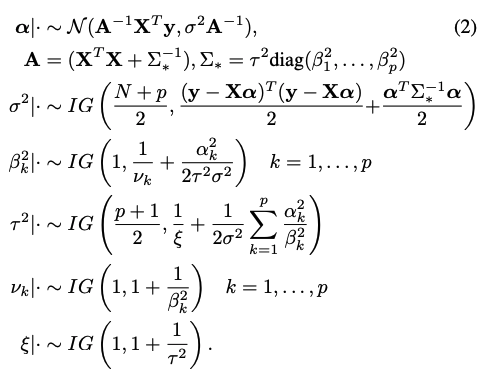

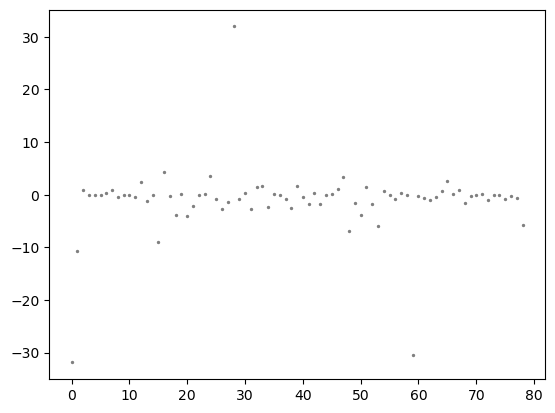

In [642]:
# p
# parameters
p = sum([math.comb(d,i) for i in range(k+1)])

# - - - - - 
#  PRIOR
# - - - - - 
# sigma
sigma_2_prior = 1.0 # (?)

# tau, beta: C+(0,1)
tau_prior, beta_prior = halfcauchy.rvs(size=1), halfcauchy.rvs(size=p)

# alpha_prior
alpha_prior = np.random.multivariate_normal(mean = np.zeros(p), 
                                            cov  = np.diag(tau_prior**2 * sigma_2_prior * beta_prior**2), 
                                            size = 1).reshape(-1)

plt.scatter(range(len(alpha_prior)), alpha_prior, c='grey', alpha=1, s=2)
plt.show()

In [643]:
X.shape

np.unique(X, axis=0).shape

(49, 79)

In [644]:
np.unique(X, axis=0)

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [659]:
# - - - - - - -  
#  DATA
# - - - - - - - 
n = 15000

# generate dataset
gD, a_GT = gDict(d=d, k=k)

X = getX(n=n, d=d, k=k)

#X = np.unique(X, axis=0)

y = getY(X, d=d, g_dict=gD, errorFlag=True, sigma=1.5)

# - - - - - - -  
#  POSTERIOR
# - - - - - - - 

# xi
xi_post = invgamma.rvs(1.0, scale=1.0 + 1.0 / tau_prior**2, size=1)

# nu
nu_post = invgamma.rvs(np.ones(p), scale=1.0 + beta_prior**(-2), size=len(beta_prior))

# tau
tau_2_post = invgamma.rvs(0.5*(p+1), scale=1.0 / xi_post + (1. / (2. * sigma_2_prior)) * sum(alpha_prior**2 / beta_prior**2), size=1)

# beta
beta_2_post = invgamma.rvs(np.ones(p), scale=(1. / nu_post) + (alpha_prior**2)/(2 * sigma_2_prior * tau_2_post))

# Cov star
Cov_star     = tau_2_post * np.diag(beta_2_post)
Cov_star_inv = np.linalg.inv(Cov_star)

# sigma
sigma_2_post = invgamma.rvs(0.5*(n+p), scale=0.5*(np.linalg.norm((y - X@alpha_prior), 2)**2 + (alpha_prior.T @ Cov_star_inv @ alpha_prior)))

# A
A     = (X.T @ X) + Cov_star_inv
A_inv = np.linalg.inv(A)

# alpha_post
alpha_post = np.random.multivariate_normal(mean = A_inv @ X.T @ y, 
                                           cov  = sigma_2_post * A_inv,
                                           size = 1).reshape(-1)


Flag, min()= -106.70869999999998


In [660]:
lm1 = LinearRegression().fit(X,y)
np.sqrt(mean_squared_error(y_pred=lm1.predict(X), y_true=y))

1.5006025418663724

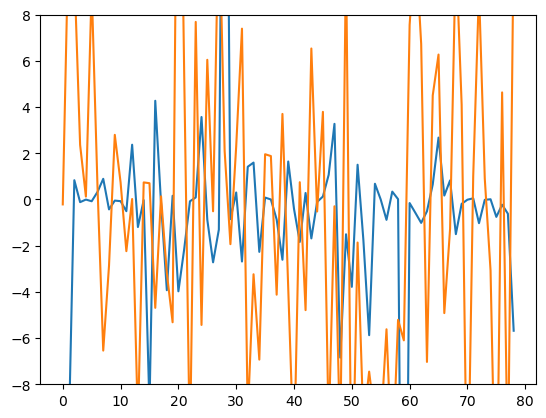

In [661]:
plt.plot(alpha_prior)
plt.plot(alpha_post)
plt.ylim((-8, 8))
plt.show()

In [662]:
print('MSE, Posteriori')
np.sqrt(mean_squared_error(y_pred=(X @ alpha_post), y_true=y))

MSE, Posteriori


4.090610301654431

In [663]:
print('MSE, Priori')
np.sqrt(mean_squared_error(y_pred=(X @ alpha_prior), y_true=y))

MSE, Priori


50.01621345338721

In [664]:
print('MSE, naïve')
np.sqrt(mean_squared_error(y_pred=[np.mean(y)]*len(y), y_true=y))

MSE, naïve


23.12948677097991

In [665]:
print('MSE, Groundtruth')
np.sqrt(mean_squared_error(y_pred=(X @ a_GT[:X.shape[1]]), y_true=y))

MSE, Groundtruth


1.5045608632824428

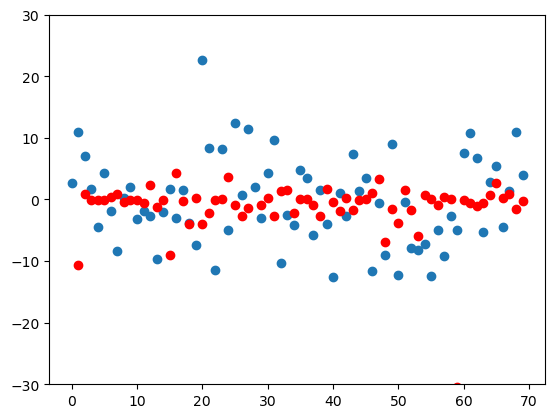

In [775]:
plt.scatter(range(70), a_GT[:70])
plt.scatter(range(70), alpha_prior[:70], c='red')
plt.ylim((-30,30))
plt.show()

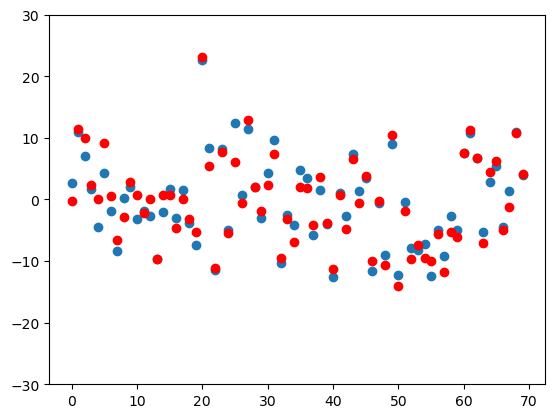

In [776]:
plt.scatter(range(70), a_GT[:70])
plt.scatter(range(70), alpha_post[:70], c='red')
plt.ylim((-30,30))
plt.show()

In [671]:
np.linalg.cond(A)

606.0795174281781

## (3.) Acquisition Function

### P1
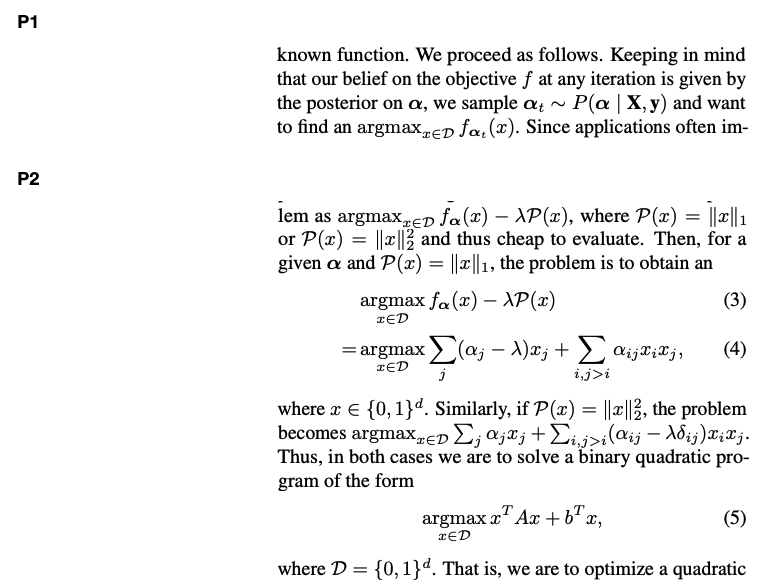


In [773]:
# Optimization
lamb  = 0.5
alpha = alpha_post

# norm
P_x = np.linalg.norm(x=np.array([1,2,-3]), ord=1)
P_x

# split alpha into 1st, 2nd order terms
alpha_1 = alpha[1:1+d]
alpha_2 = alpha[1+d:]

# A: upper triangular matrix of 2nd order coefficients
A = np.zeros((d,d))
A[np.triu_indices(d, k=1)] = alpha_2

# b
b = alpha_1 - lamb*np.ones_like(alpha_1)

# 
np.random.seed(55)
x = np.random.binomial(n=1, p=0.5, size=d)

# output
x.T @ A @ x + b @ x

-20.94506161773137

## (3.) Acquisition Function

### P3
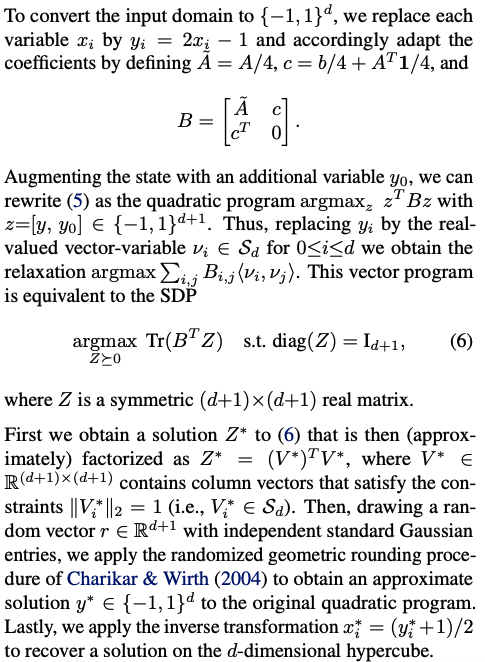


In [839]:
# BQP -> SDP
A_tilde = 0.25 * A
c = 0.25 * (b + A.T @ np.ones(d))

B = np.concatenate((A_tilde, c.reshape(d,1)), axis=1)
B = np.concatenate((B, np.pad(c, (0,1)).reshape(1,d+1)), axis=0)

In [842]:
B[-1,:]

array([ 2.74667717, -0.06796286, -0.70678513, -0.13922469,  2.99230823,
        3.16241781, -5.82293364, -6.49421741,  7.98811822, -6.41692087,
       -2.39521094, -7.39116893,  0.        ])

In [843]:
c.T

array([ 2.74667717, -0.06796286, -0.70678513, -0.13922469,  2.99230823,
        3.16241781, -5.82293364, -6.49421741,  7.98811822, -6.41692087,
       -2.39521094, -7.39116893])

In [817]:
np.concatenate((c.reshape(1,d), np.zeros(1).reshape(1,1)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 1

In [835]:
np.pad(c, (0,1)).shape

(13,)

In [823]:
A_tilde.shape, c.reshape(-1).shape

((12, 12), (12,))

In [779]:
c.shape, A_tilde.shape

((12,), (12, 12))

## (4.) BOCS Agorithm

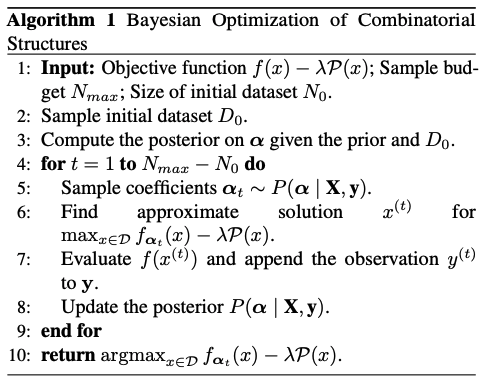